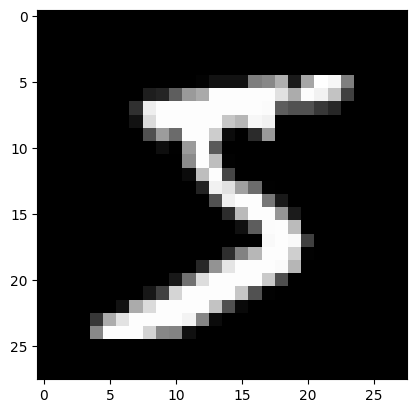

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[0],cmap='gray');

In [2]:
import numpy as np

def sigmoid(x):
  # Numerically stable sigmoid function based on
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

  x = np.clip(x, -500, 500) # We get an overflow warning without this

  return np.where(
    x >= 0,
    1 / (1 + np.exp(-x)),
    np.exp(x) / (1 + np.exp(x))
  )

def dsigmoid(x): # Derivative of sigmoid
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  # Numerically stable softmax based on (same source as sigmoid)
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max=10):
  # x: integer to convert to one hot encoding
  # max: the size of the one hot encoded array
  result = np.zeros(max)
  result[x] = 1
  return result

In [3]:
import math

from numpy.random import default_rng

rng = default_rng(80085)

def initialize_weights(layer_sizes):
  # function that initializes weight matrices for the given list of layer sizes
  num_layers = len(layer_sizes)
  weights = []
  for i in range(1, num_layers):
    # np.random.normal() function is used to generate a weight matrix filled with
    # random values from a normal distribution of mean 0 and standard deviation
    # 1/sqrt(n), where n is the number of inputs
    weight_matrix = rng.normal(loc=0.0,
                               scale=1.0/np.sqrt(layer_sizes[i-1]),
                               size=(layer_sizes[i], layer_sizes[i-1]))
    weights.append(weight_matrix)
  return weights

def initialize_biases(layer_sizes):
  # function that initializes bias matrices for the given list of layer sizes
  num_layers = len(layer_sizes)
  biases = []
  for i in range(1, num_layers):
    # np.zeros() function is used to generate a vector of zeros
    bias_vector = np.zeros(shape=(layer_sizes[i], 1))
    biases.append(bias_vector)
  return biases

# we are given the following layer sizes in the question
layer_sizes = [784, 32, 32, 10]

# initialising weights and biases using the functions
weights = initialize_weights(layer_sizes)
biases = initialize_biases(layer_sizes)

# printing the sizes of weights and bias matrices to verify
for i, weight_matrix in enumerate(weights):
    print(f"Layer {i+1} weights shape:", weight_matrix.shape)

for i, bias_vector in enumerate(biases):
    print(f"Layer {i+1} biases shape:", bias_vector.shape)

Layer 1 weights shape: (32, 784)
Layer 2 weights shape: (32, 32)
Layer 3 weights shape: (10, 32)
Layer 1 biases shape: (32, 1)
Layer 2 biases shape: (32, 1)
Layer 3 biases shape: (10, 1)


In [4]:
def feed_forward_sample(sample, y):
  # sample is a 28, 28, 1 image.
  # We rehape it to (784, 1) using the numpy reshape(-1, 1) function
  # We create a list - 'activations', that stores the results of neurons
  # The first item of activations list is the input sample
  activations = [sample.reshape(-1, 1)]

  # Now, we iterate over the length of the weight list to calculate the
  # results of neurons
  for i in range(len(weights)):
    # z = w.X + b
    z = np.dot(weights[i], activations[-1]) + biases[i]
    # a = sigmoid(z) if hidden layer, a = softmax(z) if output layer
    if i < len(weights) - 1:
      a = sigmoid(z)
    else:
      a = softmax(z)
    activations.append(a)

  # Get the one_hot_guess from the result of the last layer
  output_activations = activations[-1]
  # np.argmax() function gives the index of the number with the highest value
  # which is the most likely class index
  most_likely_class_index = np.argmax(output_activations)
  # we get the one_hot_guess using the integer_to_one_hot helper function
  one_hot_guess = integer_to_one_hot(most_likely_class_index)

  # calculating the loss between the true label, and prediction using the
  # cross_entropy_loss helper function
  loss = cross_entropy_loss(integer_to_one_hot(y), output_activations.T)

  return loss, one_hot_guess


def feed_forward_dataset(x, y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], 10))

  # iterate over the size of x, and run feed_forward_sample on each datapoint
  for i in range(x.shape[0]):
    loss, one_hot_guess = feed_forward_sample(x[i], y[i])
    # store the loss and one_hot_guess in a np array
    losses[i] = loss
    one_hot_guesses[i] = one_hot_guess.flatten()

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))
  print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")

def feed_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def feed_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")

feed_forward_test_data()

Feeding forward all test data...

Average loss: 2.36
Accuracy (# of correct guesses): 994.0 / 10000 ( 9.94 %)



In [5]:
def train_one_sample(sample, y, learning_rate=0.003):
  # sample is a 28, 28, 1 image.
  # We rehape it to (784, 1) using the numpy reshape(-1, 1) function
  # We will store each layer's activations to calculate gradient
  # The first item of activations list is the input sample
  activations = [sample.reshape(-1, 1)]

  # -- FORWARD PASS --
  # Now, we iterate over the length of the weight list to calculate the
  # results of neurons
  for i in range(len(weights)):
    # z = w.X + b
    z = np.dot(weights[i], activations[-1]) + biases[i]
    # a = sigmoid(z) if hidden layer, a = softmax(z) if output layer
    if i < len(weights) - 1:
      a = sigmoid(z)
    else:
      a = softmax(z)
    activations.append(a)

  # -- BACKWARD PASS --
  # initialising empty arrays to store the weight gradients
  dw = [np.zeros_like(w) for w in weights]
  db = [np.zeros_like(b) for b in biases]

  # delta calculation for last layer
  # Cross-entropy derivative with respect to softmax
  delta = activations[-1] - np.eye(len(activations[-1]))[y].reshape(-1, 1)
  dw[-1] = np.dot(delta, activations[-2].T)
  db[-1] = delta

  # delta calculation for other layers
  for l in range(2, len(weights) + 1):
    delta = np.dot(weights[-l+1].T, delta) * dsigmoid(np.dot(weights[-l], activations[-l-1]) + biases[-l])
    dw[-l] = np.dot(delta, activations[-l-1].T)
    db[-l] = delta

  # Update weights & biases based on calculated gradient
  for i in range(len(weights)):
    weights[i] -= learning_rate * dw[i]
    biases[i] -= learning_rate * db[i]

In [6]:
def train_one_epoch(learning_rate=0.003):
  print("Training for one epoch over the training dataset...")

  # iterating over x_train, and run train_one_sample on each datapoint
  for i in range(x_train.shape[0]):
    train_one_sample(x_train[i], y_train[i])

  print("Finished training.\n")


feed_forward_test_data()

def test_and_train():
  train_one_epoch()
  feed_forward_test_data()

for i in range(3):
  test_and_train()

Feeding forward all test data...

Average loss: 2.36
Accuracy (# of correct guesses): 994.0 / 10000 ( 9.94 %)

Training for one epoch over the training dataset...
Finished training.

Feeding forward all test data...

Average loss: 0.97
Accuracy (# of correct guesses): 6843.0 / 10000 ( 68.43 %)

Training for one epoch over the training dataset...
Finished training.

Feeding forward all test data...

Average loss: 1.05
Accuracy (# of correct guesses): 6445.0 / 10000 ( 64.45 %)

Training for one epoch over the training dataset...
Finished training.

Feeding forward all test data...

Average loss: 0.94
Accuracy (# of correct guesses): 6820.0 / 10000 ( 68.20 %)

